## UZOP PROJEKT - TREĆI DIO
# Replikacija rezultata i poboljšanje
U ovom notebooku provedena je replikacija i proširenje rezultata iz odabranog znanstvenog članka. Analiza uključuje pripremu podataka, izgradnju i evaluaciju više modela strojnog učenja te usporedbu njihovih performansi pomoću standardnih metričkih i grafičkih prikaza.

Autori: 
- Lucija Lovrić
- Karla Šoštar
- Karlo Lučan

**Opis skupa podataka**

Skup podataka "Open University Learning Analytics Dataset" (OULAD) anonimizirani je skup podataka koji sadrži informacije o studentima i njihovim interakcijama u online okruženju za učenje na Open University u Ujedinjenom Kraljevstvu (UK). Ovaj skup podataka obuhvaća 32 593 studenata upisana na 7 online kolegija.

Podaci uključuju demograske (spol, dobna skupina, razina obrazovanja, invaliditet), kao i bihevioralne varijable (broj klikova u VLE-u, datum registracije, prethodni pokušaji polaganja kolegija, rezultat prvog zadatka). Ciljnu varijablu predstavlja konačni ishod studenta koja može biti klasificirana u 4 kategorije: Withdrawn (povlačenje sa studija), Fail (pad), Pass (prolaz) i Distinction (dobivanje posebnog priznanja).

# Učitavanje podataka

In [115]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from bartpy.sklearnmodel import SklearnModel
from IPython.display import Markdown, display
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    accuracy_score,
    auc,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
    roc_curve,
)
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

In [116]:
df = pd.read_csv("data_projekt_3_Karla.csv")

Podatke smo očistili od monotonih, konstantnih, nedostajućih i stršećih vrijednosti u sklopu drugog dijela projekta te smo ih od tamo izveli i uveli u ovu Jupyter bilježnicu. U nastavku smo priložili osnovne informacije o dataframe-u, kao i kratki uvid u njegovih prvih nekoliko redaka.

In [117]:
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 32593 entries, 0 to 32592
Data columns (total 24 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   code_module                 32593 non-null  str    
 1   code_presentation           32593 non-null  str    
 2   id_student                  32593 non-null  float64
 3   gender                      32593 non-null  str    
 4   region                      32593 non-null  str    
 5   highest_education           32593 non-null  str    
 6   imd_band                    32593 non-null  str    
 7   age_band                    32593 non-null  str    
 8   num_of_prev_attempts        32593 non-null  float64
 9   studied_credits             32593 non-null  float64
 10  disability                  32593 non-null  str    
 11  final_result                32593 non-null  str    
 12  date_registration           32593 non-null  float64
 13  date_unregistration         32593 non-null

In [118]:
df.head()

,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,...,first_assignment_score,clicks_total,clicks_pre_start,clicks_post_start,submitted_first_assignment,imd_band_num,age_band_num,highest_education_num,gender_num,disability_num
0,AAA,2013J,0.002823,M,East Anglian Region,HE Qualification,90-100%,55<=,0.0,0.336,...,0.782178,0.038693,0.026266,0.035603,1.0,1.000000,1.0,0.50,1.0,0.0
1,AAA,2013J,0.009092,F,Scotland,HE Qualification,20-30%,35-55,0.0,0.048,...,0.702970,0.059447,0.057625,0.051957,1.0,0.222222,0.5,0.50,0.0,0.0
2,AAA,2013J,0.009780,F,North Western Region,A Level or Equivalent,30-40%,35-55,0.0,0.048,...,0.000000,0.011641,0.027339,0.007623,0.0,0.333333,0.5,0.25,0.0,1.0
3,AAA,2013J,0.010273,F,South East Region,A Level or Equivalent,50-60%,35-55,0.0,0.048,...,0.722772,0.089399,0.045296,0.084707,1.0,0.555556,0.5,0.25,0.0,0.0
4,AAA,2013J,0.010745,F,West Midlands Region,Lower Than A Level,50-60%,0-35,0.0,0.048,...,0.693069,0.042835,0.079067,0.031472,1.0,0.555556,0.0,0.00,0.0,0.0


# Replikacija rezultata

U nastavku je prikazana kovarijacijska matrica numeričkih varijabli nad kojima su primijenjeni modeli Decision Tree, Random Forest i BART, u skladu s pristupom iz izvornog članka. Dobiveni rezultati analizirani su i komentirani u nastavku rada.  
U skladu s metodologijom opisanoj u izvornom članku, podaci su podijeljeni na skup za treniranje i skup za ispitivanje u omjeru 70:30, pri čemu je 70% uzoraka korišteno za učenje modela, a preostalih 30% za evaluaciju.  

**Kovarijacijska matrica** prikazuje međusobne odnose između numeričkih značajki korištenih u modeliranju. Niske vrijednosti korelacije upućuju na odsutnost značajne multikolinearnosti među varijablama.  

**Decision Tree** je model koji donosi odluke kroz hijerarhijske podjele nad ulaznim značajkama s ciljem maksimizacije informacijske dobiti. Model je lako interpretabilan, ali osjetljiv na prenaučenost i neuravnoteženost podataka.

**Random Forest** je ansambl metoda koja kombinira više stabala odlučivanja treniranih na nasumičnim poduzorcima podataka, čime se poboljšava robusnost i generalizacija. U odnosu na pojedinačno stablo postiže stabilnije performanse.  

**BART** (Bayesian Additive Regression Trees) je Bayesovski ansambl model koji aproksimira ciljnu funkciju zbrojem regresijskih stabala i omogućuje snažnu diskriminacijsku sposobnost. Njegove performanse ovise o postavkama modela i osjetljive su na neuravnoteženost klasa.

## Kovarijacijska matrica

In [119]:
num_features = [
    "gender_num",
    "highest_education_num",
    "age_band_num",
    "num_of_prev_attempts",
    "disability_num",
    "first_assignment_score",
    "date_registration",
    "clicks_pre_start"
]

X = df[num_features].copy()
X["gender_num"] = df["gender"].map({"F": 1, "M": 0})
y = df["final_result"].copy()


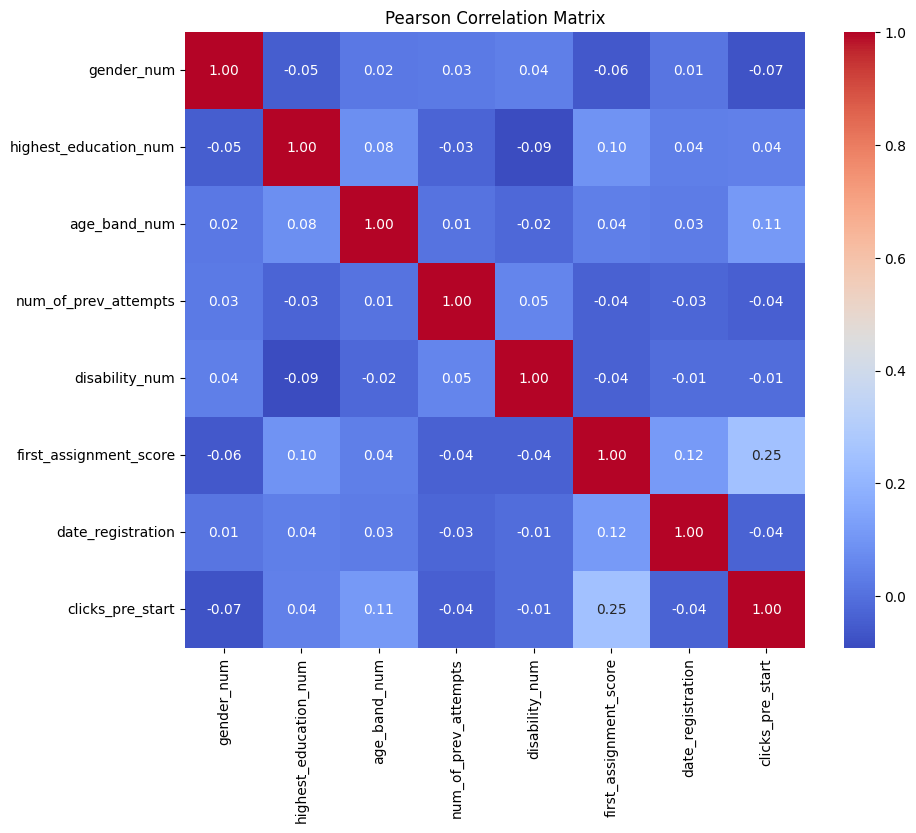

In [120]:
corr_matrix = X.corr(method="pearson")
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Pearson Correlation Matrix")
plt.show()


Za početak smo replicirali kovarijacijsku matricu iz članka sa svim numeričkim varijablama. Pearsonova korelacijska analiza provedena je kako bi se ispitao linearni odnos između ulaznih varijabli te potencijalna multikolinearnost. Dobiveni rezultati pokazuju da su korelacijski koeficijenti uglavnom vrlo niski, što je u skladu s nalazima iz izvornog članka. Najizraženija korelacija uočena je između broja klikova prije početka kolegija (clicks_pre_start) i ocjene prvog zadatka (first_assignment_score), no i ona ostaje umjerena. Ovi rezultati potvrđuju da odabrane varijable nose komplementarne informacije te je njihova zajednička upotreba u prediktivnim modelima opravdana.

In [121]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.30,
    random_state=42,
    stratify=y
)

In [122]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", "passthrough", num_features)
    ]
)


## Modeliranje i evaluacija

U nastavku su implementirani i evaluirani različiti modeli strojnog učenja. Svi modeli trenirani su na istom skupu podataka i evaluirani na istom testnom skupu kako bi usporedba bila pravedna. Za evaluaciju su korištene metrike točnosti, F1-mjere, ROC krivulje, AUC vrijednosti i matrice zabune.

### Metrike

#### točnost (accuracy)

Predstavlja omjer ispravno klasificiranih primjera u odnosu na ukupan broj primjera, odnosno, koliki postotak svih predviđanja je model ispravno predvidio.
Intuitivna je i lako razumljiva metrika, ali kod vrlo neuravnoteženih skupova podataka može biti obmanjujuća.
Kako se zapravo radi o vjerojatnosti, vrijednosti su joj u rasponu od 0 (svi primjeri krivo klasificirani) do 1 (svi primjeri su ispravno klasificirani).

#### F1-mjera (F1- score)

Računa se kao harmonijska sredina preciznosti i odziva.

Preciznost označava koliko je pozitivnih predviđanja zapravo ispravno u odnosu na ukupan broj pozitivnih predviđanja.
Odaziv predstavlja broj ispravnih pozitivnih predviđanja u omjeru na broj stvarno pozitivnih primjera. 

F1-mjera povezuje obje ove metrike u jednu. U usporedbi s točnosti posebno je korisna kod neuravnoteženih skupova podataka.
Kao i točnost, poprima vrijednosti od 0 do 1, s time da 1 označava savršeni rezultat.

#### ROC krivulja (Receiver Operating Characteristic)

ROC krivulja prikazuje odnos između stope istinitih pozitivnih rezultata i stope lažno pozitivnih rezultata za različite pragove klasifikacije.
Daje nam uvid u ponašanje modela pri različitim pragovima klasifikacije.
Savršena ROC krivulja bi prolazila kroz gornji lijevi kut, što bi značilo da model ispravno klasificira sve primjere za svaki prag odlučnosti, odnosno da je 100% točan pri predviđanju.


#### AUC (Area Under Curve)

Označava površinu ispod ROC krivulje. Govori nam vjerojatnost da će model rangirati nasumično odabrani pozitivni primjer višlje od nnasumično izabranog negativnog modela.
Poprima vrijednosti od 0 do 1, gjde je 1 savršeni klasifikator. Vrijednosti manje od 0.5 označavaju da je model gori od nasumičnog.
Koristan je za usporedbu različitih modela i otporan na neuravnotežene skupove podataka.

#### matrica zabune (confusion matrix)

Prikazuje četiri moguća ishoda klasifikacije: stvarno pozitivno, stvarno negativno, lažno pozitivno, lažno negativno.
Daje nam detaljan uvid u klasifikaciju cijelog skupa i može nam ukazivat ne samo griješi li model nego gdje griješi.

Vrijednosti iz matrice zabune koriste se pri izračunu svih već nabrojanih metrika.


## Decision Tree (One-vs-Rest)

In [123]:
dt_model = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("clf", OneVsRestClassifier(
        DecisionTreeClassifier(random_state=42)
    ))
])

dt_model.fit(X_train, y_train)


,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocess', ...), ('clf', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers contains sparse matr

## Random Forest (One-vs-Rest)

In [124]:
rf_model = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("clf", OneVsRestClassifier(
        RandomForestClassifier(
            n_estimators=300,
            random_state=42,
            class_weight="balanced",
            n_jobs=-1
        )
    ))
])

rf_model.fit(X_train, y_train)


,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocess', ...), ('clf', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers contains sparse matr

## BART model (One-vs-Rest)

In [125]:
def bart_ovr_one_class(
    X_train, y_train, X_test, y_test,
    positive_class,
    n_trees=50,
    n_burn=250,
    n_samples=250
):
    
    # Binarizacija
    y_train_bin = (y_train == positive_class).astype(int)
    y_test_bin = (y_test == positive_class).astype(int)
    
    if hasattr(y_train_bin, "to_numpy"):
        y_train_bin = y_train_bin.to_numpy()
    else:
        y_train_bin = np.asarray(y_train_bin)
    
    if hasattr(y_test_bin, "to_numpy"):
        y_test_bin = y_test_bin.to_numpy()
    else:
        y_test_bin = np.asarray(y_test_bin)
    
    Xtr = X_train.to_numpy() if hasattr(X_train, "to_numpy") else np.asarray(X_train)
    Xte = X_test.to_numpy() if hasattr(X_test, "to_numpy") else np.asarray(X_test)
    
    # Normalizacija
    scaler = StandardScaler()
    Xtr_scaled = scaler.fit_transform(Xtr)
    Xte_scaled = scaler.transform(Xte)
    
    # BART model
    model = SklearnModel(
        n_trees=n_trees,
        n_burn=n_burn,
        n_samples=n_samples,
        alpha=0.95,
        beta=2.0
    )
    model.fit(Xtr_scaled, y_train_bin)
    
    # Predict na train i test
    y_score_train = np.asarray(model.predict(Xtr_scaled), dtype=float).reshape(-1)
    y_score_test = np.asarray(model.predict(Xte_scaled), dtype=float).reshape(-1)
    
    # Optimalni threshold na train
    mask_train = np.isfinite(y_score_train)
    y_score_train_clean = y_score_train[mask_train]
    y_train_bin_clean = y_train_bin[mask_train]
    
    optimal_threshold = 0.5
    fpr_train, tpr_train, thresholds_train = None, None, None
    
    if len(np.unique(y_train_bin_clean)) == 2:
        fpr_train, tpr_train, thresholds_train = roc_curve(y_train_bin_clean, y_score_train_clean)
        j_scores = tpr_train - fpr_train
        optimal_idx = np.argmax(j_scores)
        optimal_threshold = thresholds_train[optimal_idx]
    
    # Očisti test NaN
    mask_test = np.isfinite(y_score_test)
    n_removed = int((~mask_test).sum())
    
    if n_removed > 0:
        print(f"[WARN] {positive_class}: removed {n_removed} non-finite predictions")
    
    y_score_clean = y_score_test[mask_test]
    y_test_bin_clean = y_test_bin[mask_test]
    
    if y_score_clean.size == 0:
        raise ValueError(f"BART returned no valid predictions for '{positive_class}'")
    
    # Threshold
    y_pred_clean = (y_score_clean >= optimal_threshold).astype(int)
    
    # Metrike
    class_labels = [0, 1]
    cm = confusion_matrix(y_test_bin_clean, y_pred_clean, labels=class_labels)
    
    auc_val = np.nan
    fpr, tpr, thresholds = None, None, None
    
    if len(np.unique(y_test_bin_clean)) == 2:
        auc_val = roc_auc_score(y_test_bin_clean, y_score_clean)
        fpr, tpr, thresholds = roc_curve(y_test_bin_clean, y_score_clean)
    
    return {
        "class": positive_class,
        "precision": precision_score(y_test_bin_clean, y_pred_clean, zero_division=0),
        "recall": recall_score(y_test_bin_clean, y_pred_clean, zero_division=0),
        "f1": f1_score(y_test_bin_clean, y_pred_clean, zero_division=0),
        "accuracy": accuracy_score(y_test_bin_clean, y_pred_clean),
        "auc": auc_val,
        "n_removed_nan": n_removed,
        "optimal_threshold": optimal_threshold,
        "cm": cm,
        "fpr": fpr,
        "tpr": tpr,
        "y_test_bin": y_test_bin_clean,
        "y_pred_bin": y_pred_clean,
        "y_score": y_score_clean
    }

def bart_visualize_results(result):
    
    positive_class = result['class']
    cm = result['cm']
    auc_val = result['auc']
    fpr = result['fpr']
    tpr = result['tpr']
    
    if fpr is None or tpr is None or np.isnan(auc_val):
        print(f"[WARN] Cannot visualize {positive_class}: insufficient data for ROC")
        return
    
    class_labels = [0, 1]
    label_names = [f"Not {positive_class}", positive_class]
    
    fig, axes = plt.subplots(1, 2, figsize=(13, 5))
    
    # Matrica zabune
    ConfusionMatrixDisplay.from_predictions(
        result['y_test_bin'],
        result['y_pred_bin'],
        labels=class_labels,
        display_labels=label_names,
        ax=axes[0],
        cmap="Blues",
        colorbar=False,
        values_format="d"
    )
    axes[0].set_title(
        f"Matrica zabune (BART)\n{positive_class} vs Rest",
        fontsize=12,
        fontweight='bold',
        pad=15
    )
    axes[0].set_xlabel("Predviđena klasa", fontsize=11)
    axes[0].set_ylabel("Stvarna klasa", fontsize=11)
    
    # ROC krivulja
    axes[1].plot(fpr, tpr, label=f"AUC = {auc_val:.3f}", linewidth=2.5, color='#2E86AB')
    axes[1].plot([0, 1], [0, 1], linestyle="--", color='gray', alpha=0.6, label='Nasumično')
    axes[1].fill_between(fpr, tpr, alpha=0.2, color='#2E86AB')
    axes[1].set_xlabel("Stopa lažno pozitivnih (FPR)", fontsize=11)
    axes[1].set_ylabel("Stopa istinitih pozitivnih (TPR)", fontsize=11)
    axes[1].set_title(
        f"ROC krivulja (BART)\n{positive_class} vs Rest",
        fontsize=12,
        fontweight='bold',
        pad=15
    )
    axes[1].legend(fontsize=10, loc='lower right')
    axes[1].grid(alpha=0.3, linestyle='--')
    axes[1].set_xlim([-0.02, 1.02])
    axes[1].set_ylim([-0.02, 1.02])
    
    plt.tight_layout()
    plt.show()

In [126]:
classes = ["Withdrawn", "Fail", "Pass", "Distinction"]

bart_results = []

for c in classes:
    res = bart_ovr_one_class(
        X_train, y_train, X_test, y_test,
        positive_class=c,
        n_trees=50,
        n_burn=200,
        n_samples=200,
    )
    bart_results.append(res)

/home/karlo/UZOP/.venv/lib/python3.14/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Starting burn


  0%|          | 0/200 [00:00<?, ?it/s]

Starting burn
Starting burn


  0%|          | 1/200 [00:01<03:54,  1.18s/it]

Starting burn


 68%|██████▊   | 137/200 [00:16<00:06, 10.14it/s]

Starting sampling


 83%|████████▎ | 166/200 [00:21<00:04,  7.85it/s]

Starting sampling


 98%|█████████▊| 197/200 [00:24<00:00, 10.82it/s]

Starting sampling


  0%|          | 0/200 [00:00<?, ?it/s]

Starting sampling


100%|██████████| 200/200 [00:22<00:00,  9.03it/s]


Starting burn
Starting burn
Starting burn
Starting burn


 98%|█████████▊| 195/200 [00:18<00:00, 11.50it/s]

Starting sampling
Starting sampling


100%|█████████▉| 199/200 [00:19<00:00, 11.48it/s]

Starting sampling
Starting sampling


100%|██████████| 200/200 [00:24<00:00,  8.27it/s]


Starting burn
Starting burn


 16%|█▋        | 33/200 [00:02<00:09, 17.64it/s]

Starting burn


 25%|██▌       | 50/200 [00:03<00:07, 19.35it/s]

Starting burn


  0%|          | 0/200 [00:00<?, ?it/s]

Starting sampling


 70%|███████   | 141/200 [00:15<00:07,  7.64it/s]

Starting sampling


  0%|          | 0/200 [00:00<?, ?it/s]

Starting sampling
Starting sampling


100%|██████████| 200/200 [00:18<00:00, 10.77it/s]


Starting burn


  0%|          | 0/200 [00:00<?, ?it/s]

Starting burn
Starting burn


 11%|█         | 22/200 [00:01<00:10, 16.65it/s]

Starting burn


 46%|████▌     | 92/200 [00:13<00:09, 11.01it/s]]

Starting sampling


  0%|          | 1/200 [00:00<00:20,  9.84it/s]s]

Starting sampling


 31%|███       | 62/200 [00:06<00:37,  3.72it/s]]

Starting sampling


  0%|          | 0/200 [00:00<?, ?it/s]

Starting sampling


100%|██████████| 200/200 [00:15<00:00, 12.61it/s]


In [127]:
y_pred_dt = dt_model.predict(X_test)
y_pred_rf = rf_model.predict(X_test)

print("=== Decision Tree ===")
print(classification_report(y_test, y_pred_dt))

print("\n=== Random Forest ===")
print(classification_report(y_test, y_pred_rf))

for res in bart_results:
    print(f"\n=== BART: {res["class"]} vs Rest ===")
    print(classification_report(
        res["y_test_bin"],
        res["y_pred_bin"],
        target_names=[f"Not {res["class"]}", str(res["class"])],
        zero_division=0
    ))

=== Decision Tree ===
              precision    recall  f1-score   support

 Distinction       0.15      0.46      0.23       907
        Fail       0.29      0.30      0.29      2116
        Pass       0.52      0.36      0.43      3708
   Withdrawn       0.65      0.46      0.54      3047

    accuracy                           0.39      9778
   macro avg       0.40      0.40      0.37      9778
weighted avg       0.48      0.39      0.42      9778


=== Random Forest ===
              precision    recall  f1-score   support

 Distinction       0.30      0.14      0.19       907
        Fail       0.33      0.24      0.28      2116
        Pass       0.52      0.74      0.61      3708
   Withdrawn       0.67      0.57      0.62      3047

    accuracy                           0.52      9778
   macro avg       0.46      0.42      0.43      9778
weighted avg       0.51      0.52      0.50      9778


=== BART: Withdrawn vs Rest ===
               precision    recall  f1-score   suppo

Nad podacima su provedena tri modela, Decision Tree, Random Forest i BART, čiji su rezultati prikazani iznad.  

**Decision Tree model**  

Decision Tree model postiže ukupnu točnost od 0.43, uz macro F1-score od 0.33, što ukazuje na ograničene performanse modela na neuravnoteženom višeklasnom problemu. Najslabiji rezultati ostvareni su za klase Distinction i Fail, gdje je recall izrazito nizak (0.10 za Distinction i 0.15 za Fail), što znači da model prepoznaje tek mali dio studenata koji stvarno pripadaju tim klasama.  

S druge strane, klasa Withdrawn pokazuje znatno bolje rezultate, s recall vrijednošću od 0.71, što ukazuje da Decision Tree relativno uspješno identificira studente koji odustaju od kolegija, ali uz umjerenu preciznost. Klasa Pass postiže srednje performanse, s recall vrijednošću od 0.43, što potvrđuje da je ova klasa zahtjevnija za razdvajanje u odnosu na Withdrawn.

Ovakvi rezultati su u skladu s nalazima iz članka, gdje je Decision Tree identificiran kao najslabiji model, osobito osjetljiv na neuravnoteženost podataka i sklon lošijoj generalizaciji za manjinske klase.

**Random Forest model**  

Random Forest model pokazuje jasno poboljšanje u odnosu na Decision Tree u svim relevantnim metrikama. Ukupna točnost modela iznosi 0.53, dok se macro F1-score povećava na 0.43, što potvrđuje bolju uravnoteženost performansi po klasama.

Najbolji rezultati ostvareni su za klasu Withdrawn, gdje model postiže precision od 0.68 i recall od 0.57, što ukazuje na stabilnu i pouzdanu klasifikaciju studenata koji odustaju od kolegija. Klasa Pass pokazuje vrlo visok recall (0.75), što znači da Random Forest uspješno identificira većinu studenata koji prolaze kolegij, ali uz nižu preciznost (0.53), što upućuje na miješanje s klasama Fail i Distinction.

Za klase Fail i Distinction uočeno je poboljšanje u odnosu na Decision Tree (recall raste na 0.25 za Fail i 0.15 za Distinction), no ove vrijednosti i dalje ostaju relativno niske. To potvrđuje da su ove klase najteže za predikciju, što je u skladu s rezultatima iz članka, gdje su i uz naprednije modele zabilježene poteškoće u njihovoj klasifikaciji.

**BART**

BART model postiže nešto bolje rezultate od prijašnjih modela, kao što je i opisano u članku.
BART je One-vs-Rest model, pa tako dobivamo odvojena mjerenja za točnost za svaki par klasa i ne-klasa.

S točnošću od 0.82 točno predviđa Withdrawn vs Rest, što je u skladu sa člankom. Dok je u našem slučaju drugi najbolji rezultat za klasu distinction (0.70), za razliku od članka gdje je to najbolji rezultat s preciznošću od 0.92.

U članku nije definirano kako su određivali prag tijekom klasifikacije. U našem slučaju BART određuje optimalni prag iz ROC krivulje.

## AUC, ROC, matrica zabune

In [128]:



def evaluate_ovr(model, X_test, y_test, class_name, label_encoder=None):

    # Odredi display name i comparison value
    if isinstance(class_name, int) and label_encoder is not None:
        # XGBoost slučaj - pretvori int u ime
        display_name = label_encoder.inverse_transform([class_name])[0]
        comparison_value = class_name
    else:
        # Ostali modeli - koristi string direktno
        display_name = class_name
        comparison_value = class_name
    
    # Binarizacija: class vs rest
    y_true_bin = (y_test == comparison_value).astype(int)

    # Predict class probabilities
    proba = model.predict_proba(X_test)
    classes = model.named_steps["clf"].classes_
    
    # Nađi index klase
    if isinstance(comparison_value, int):
        idx = comparison_value
    else:
        idx = list(classes).index(comparison_value)
    
    y_score = proba[:, idx]

    # Threshold 0.5 for binary decision
    y_pred_bin = (y_score >= 0.5).astype(int)

    # Labele za matricu zabune
    class_labels = [0, 1]
    label_names = [f"Not {display_name}", display_name]

    # Matrica zabune
    cm = confusion_matrix(y_true_bin, y_pred_bin, labels=class_labels)

    # ROC/AUC
    fpr, tpr, _ = roc_curve(y_true_bin, y_score)
    roc_auc = auc(fpr, tpr)

    # Vizualizacija
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        cbar=False,
        ax=axes[0],
        xticklabels=label_names,  # ← LABELE
        yticklabels=label_names   # ← LABELE
    )
    axes[0].set_xlabel("Predviđena klasa", fontsize=11)
    axes[0].set_ylabel("Stvarna klasa", fontsize=11)
    axes[0].set_title(
        f"Matrica zabune\n{display_name} vs Rest",
        fontsize=12,
        fontweight='bold'
    )

    # ROC
    axes[1].plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}", linewidth=2)
    axes[1].plot([0, 1], [0, 1], linestyle="--", color='gray', alpha=0.7)
    axes[1].set_xlabel("Stopa lažno pozitivnih (FPR)", fontsize=11)
    axes[1].set_ylabel("Stopa istinitih pozitivnih (TPR)", fontsize=11)
    axes[1].set_title(
        f"ROC krivulja\n{display_name} vs Rest",
        fontsize=12,
        fontweight='bold'
    )
    axes[1].legend(fontsize=10)
    axes[1].grid(alpha=0.3)

    plt.tight_layout()
    plt.show()

    return roc_auc, cm


classes_to_check = sorted(y.unique())

### Decision Tree

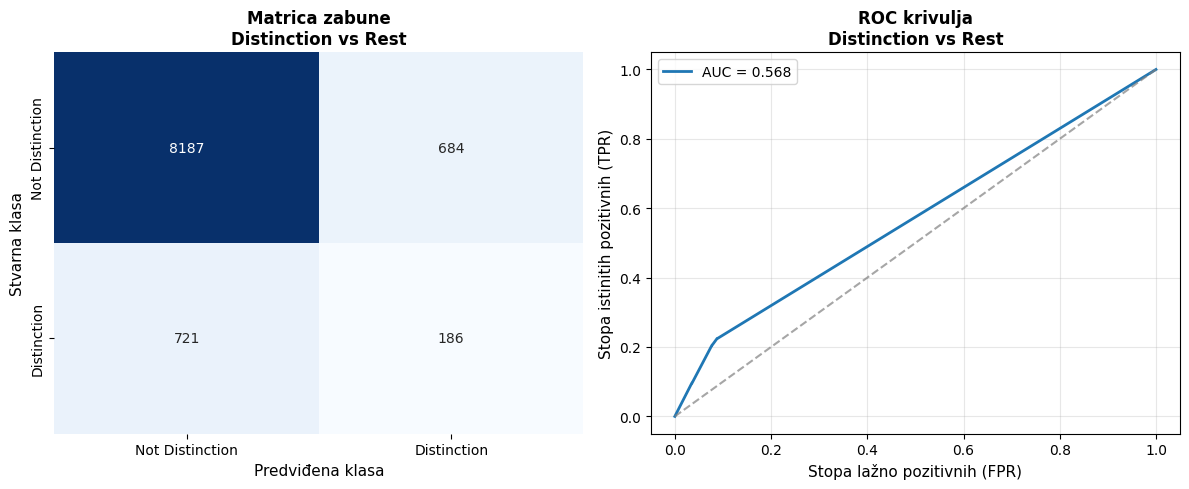

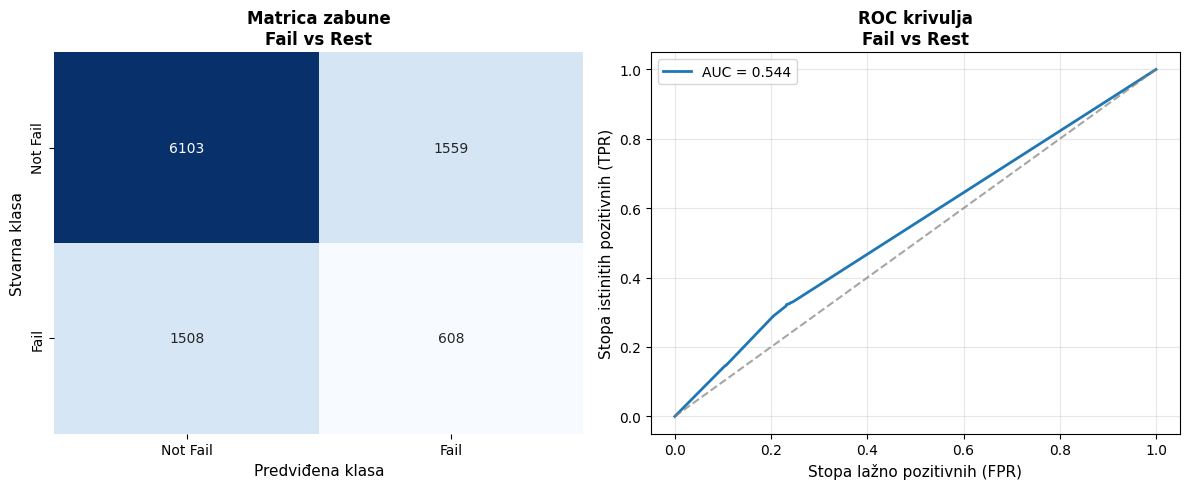

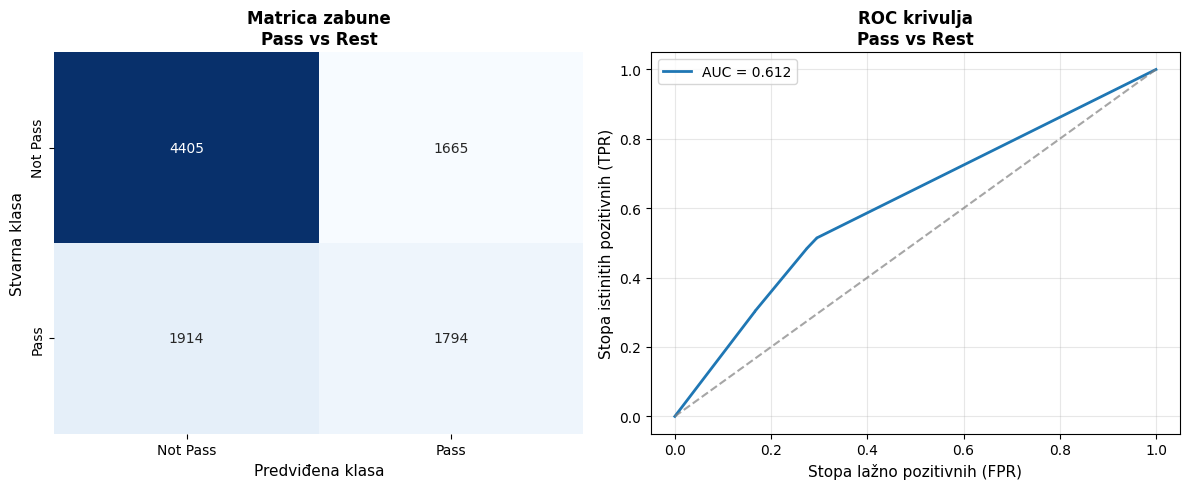

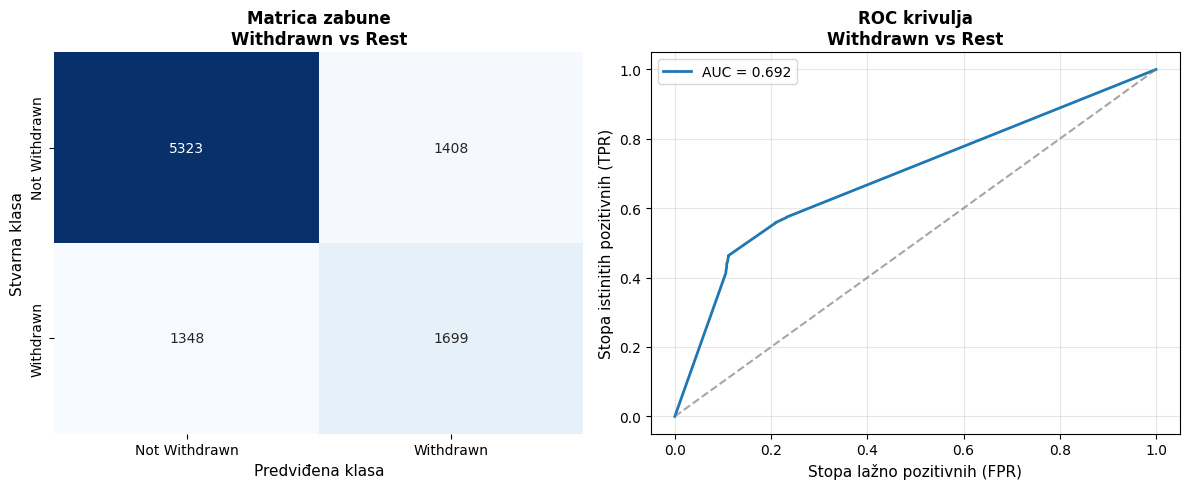

In [129]:
for c in classes_to_check:
    evaluate_ovr(dt_model, X_test, y_test, c)

**Distinction vs Rest**  

Za klasu Distinction dobivena je AUC vrijednost 0.568, što ukazuje na slabu sposobnost modela da razlikuje studente s odličnim uspjehom od ostalih. ROC krivulja nalazi se relativno blizu dijagonale (oznaka za 0.5), što potvrđuje da model tek neznatno nadmašuje slučajnu klasifikaciju. Iz matrice zabune uočava se velik broj FN predikcija (721), što znači da model velik dio stvarno odličnih studenata klasificira kao ostale, što direktno objašnjava vrlo niske vrijednosti recall metrike za ovu klasu.  

**Fail vs Rest**  

Za klasu Fail dobivena je AUC vrijednost 0.544, što predstavlja najslabiji rezultat među svim klasama i upućuje na izrazitu poteškoću modela u razdvajanju studenata koji nisu položili kolegij od ostalih. ROC krivulja gotovo se preklapa s referentnom dijagonalom, što potvrđuje slabo razdvajanje pozitivnih i negativnih uzoraka. Matrica zabune dodatno potvrđuje ovaj zaključak, budući da model proizvodi velik broj pogrešnih klasifikacija, s izraženim brojem FN (1508) i FP (1559) predikcija.  

**Pass vs Rest**

Za klasu Pass postignuta je AUC vrijednost 0.612, što ukazuje na umjerenu, ali i dalje ograničenu diskriminacijsku sposobnost modela. ROC krivulja pokazuje porast stope istinitih pozitivnih predikcija uz rast stope lažno pozitivnih predikcija, no bez jasnog razdvajanja klasa. Iz matrice zabune vidljivo je da model relativno dobro prepoznaje studente koji su položili kolegij, ali uz istovremeno velik broj FP (1665) i FN (1914) pogrešaka, što ukazuje na čestu zamjenu ove klase s ostalima.  

**Withdrawn vs Rest**  

Za klasu Withdrawn dobivena je AUC vrijednost od 0.692, što predstavlja najvišu AUC vrijednost među promatranim klasama za Decision Tree model, ali i dalje ukazuje na ograničenu diskriminacijsku sposobnost modela. ROC krivulja pokazuje umjeren porast stope istinitih pozitivnih predikcija pri nižim vrijednostima lažno pozitivne stope, no bez izraženog odvajanja od dijagonale (doduše, bolje od ostalih modela). Iz matrice zabune vidljivo je da model ispravno prepoznaje 1699 studenata koji su se povukli s kolegija, ali istovremeno propušta velik broj takvih slučajeva (1348 FN), što objašnjava umjerene vrijednosti recall metrike.

### Random Forest modeli


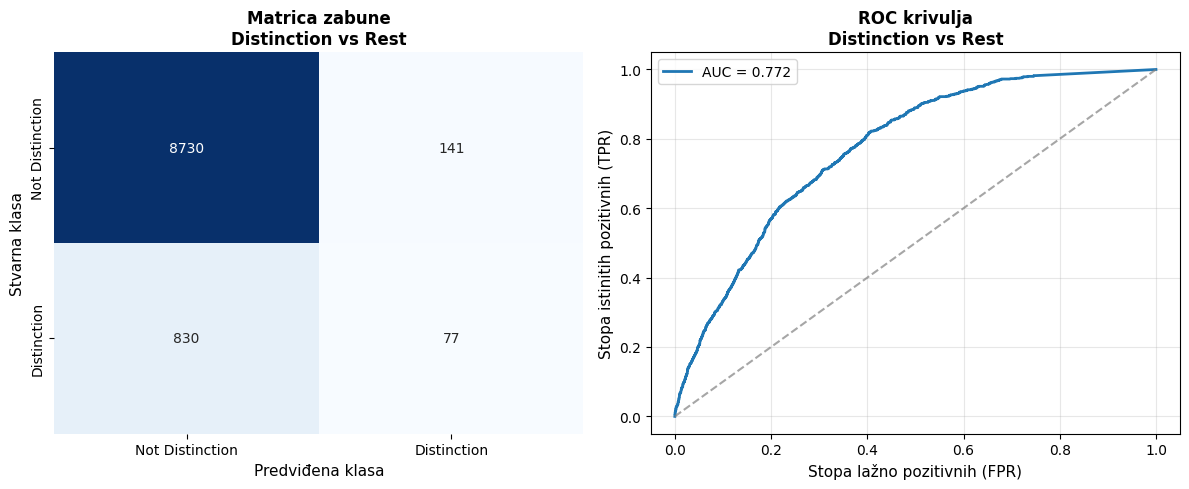

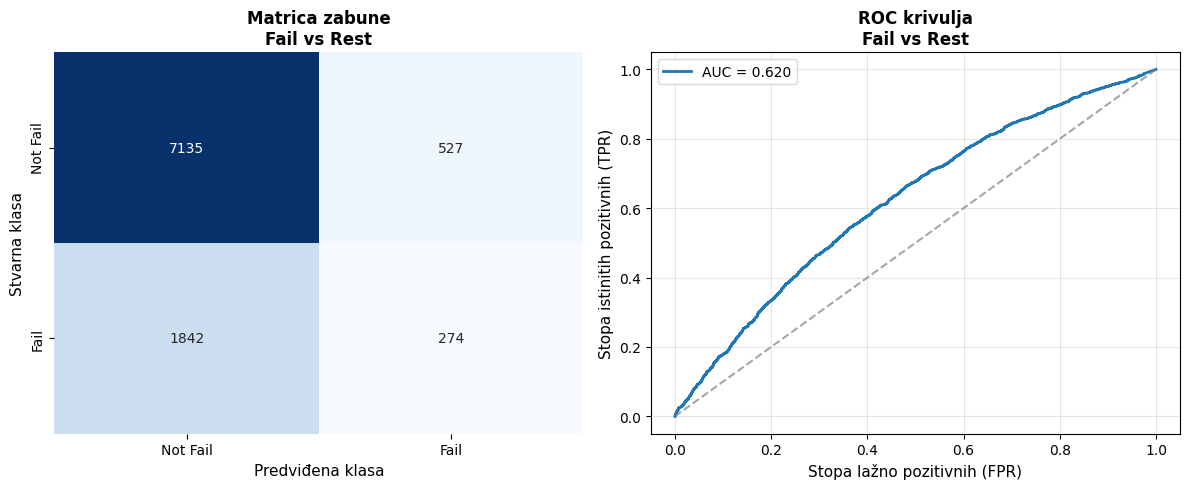

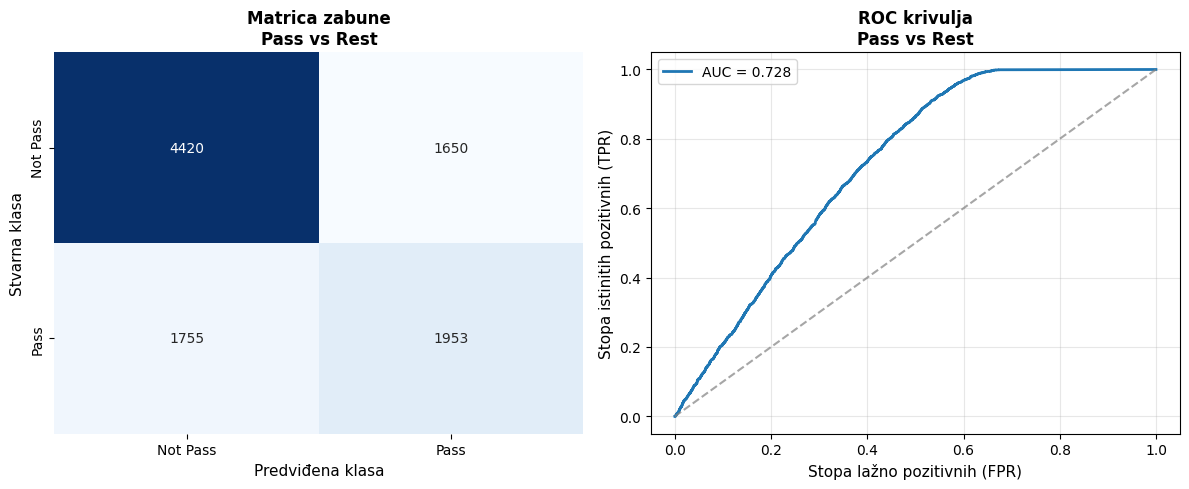

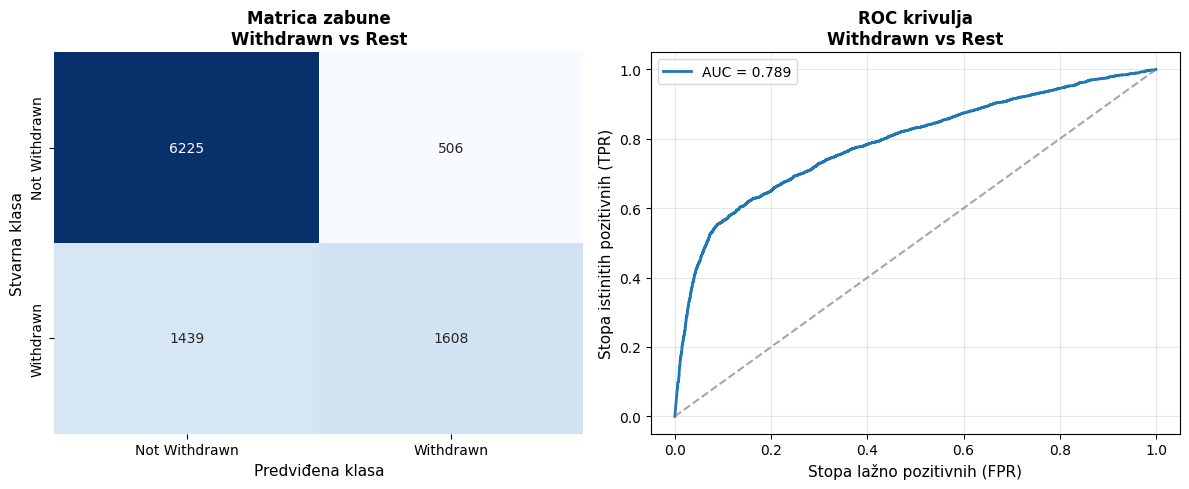

In [130]:
for c in classes_to_check:
    evaluate_ovr(rf_model, X_test, y_test, c)

**Distinction vs Rest**  

Za klasu Distinction dobivena je AUC vrijednost 0.776, što ukazuje na dobru sposobnost modela da razlikuje studente s izvrsnim uspjehom od ostalih. ROC krivulja pokazuje jasno odvajanje od dijagonale te relativno brz porast stope istinitih pozitivnih predikcija pri niskim vrijednostima lažno pozitivne stope. Iz matrice zabune vidljivo je da model i dalje ima značajan broj FN predikcija (830), što je očekivano s obzirom na neuravnoteženost klase, no u usporedbi s Decision Tree modelom uočava se poboljšanje u prepoznavanju klase Distinction, što se odražava i u višim vrijednostima recall i AUC metrike.  

**Fail vs Rest**  

Za klasu Fail postignuta je AUC vrijednost 0.621, što ukazuje na umjerenu, ali i dalje ograničenu diskriminacijsku sposobnost modela. ROC krivulja pokazuje blago poboljšanje u odnosu na Decision Tree model, no i dalje se nalazi relativno blizu dijagonale, što potvrđuje da se ova klasa najteže razdvaja od ostatka. Matrica zabune pokazuje velik broj FN (1838) i FP (521) pogrešaka, što upućuje na to da model često ne uspijeva identificirati studente koji nisu položili kolegij, slično kao i u prethodnom modelu.

**Pass vs Rest**

Za klasu Pass dobivena je AUC vrijednost 0.728, što predstavlja značajno poboljšanje u odnosu na Decision Tree model. ROC krivulja pokazuje stabilan rast stope istinitih pozitivnih predikcija uz porast lažno pozitivnih, uz vidljivo bolje razdvajanje klasa. Iz matrice zabune može se zaključiti da model relativno uspješno prepoznaje studente koji su položili kolegij, ali i dalje bilježi velik broj FP (1607) i FN (1811) predikcija, što ukazuje na preklapanje ove klase s ostalim ishodima.  

**Withdrawn vs Rest**  

Za klasu Withdrawn dobivena je najviša AUC vrijednost od 0.789, što ukazuje na dobru sposobnost modela da razlikuje studente koji su se povukli s kolegija od ostalih. ROC krivulja pokazuje strm porast stope istinitih pozitivnih predikcija pri niskim vrijednostima lažno pozitivne stope, što upućuje na dobru diskriminacijsku moć modela. Matrica zabune potvrđuje ovaj zaključak, budući da model ostvaruje povoljniji omjer TP (1613) i FP (504) vrijednosti u usporedbi s ostalim klasama, čime se ova klasa pokazuje kao najlakša za predikciju u okviru ovog modela.



## Logistička regresija (baseline model)

Logistička regresija korištena je kao **osnovni (baseline) linearni model** za usporedbu s nelinearnim modelima temeljenima na stablima odlučivanja.  
Cilj njezina uvođenja nije postizanje najboljih rezultata, već pružanje **referentne točke** kako bi se pokazalo u kojoj mjeri složeniji modeli (Decision Tree, Random Forest i BART) ostvaruju poboljšanje.


Logistička regresija – rezultati:
              precision    recall  f1-score   support

 Distinction       0.54      0.02      0.03       907
        Fail       0.45      0.08      0.13      2116
        Pass       0.52      0.91      0.66      3708
   Withdrawn       0.67      0.65      0.66      3047

    accuracy                           0.57      9778
   macro avg       0.55      0.41      0.37      9778
weighted avg       0.56      0.57      0.49      9778

Matrica zabune (Logistička regresija):
[[  14    8  854   31]
 [   1  165 1247  703]
 [   8   95 3370  235]
 [   3   95  961 1988]]
AUC (Logistička regresija): 0.7538070748133032


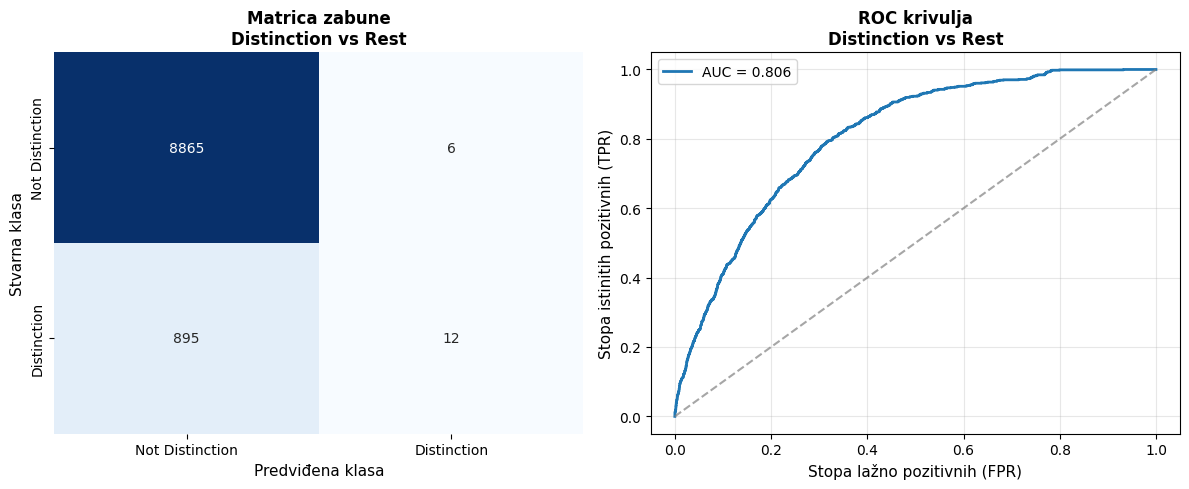

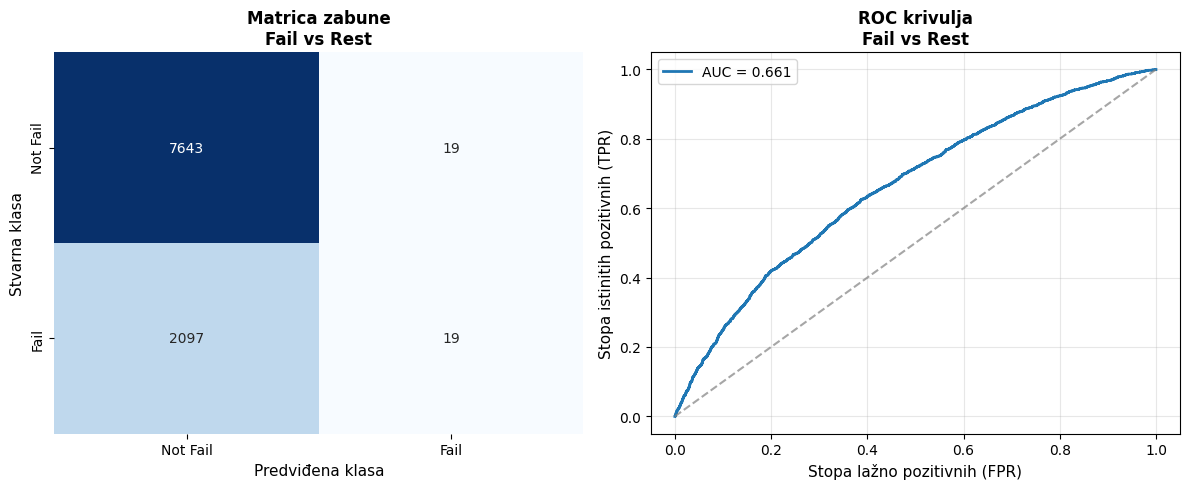

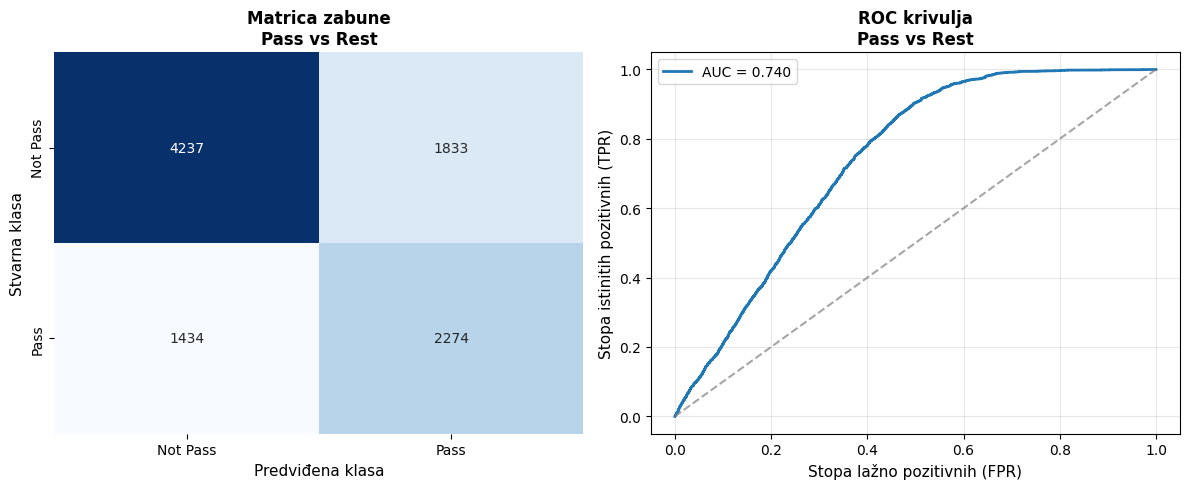

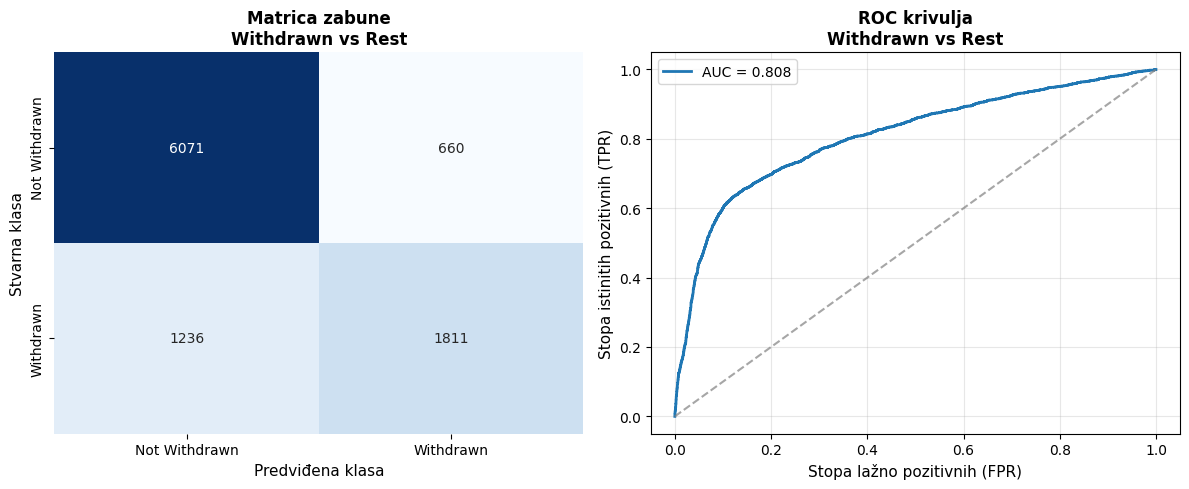

In [131]:

logreg_pipeline_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(
        #multi_class="multinomial",
        solver="lbfgs",
        max_iter=1000,
        random_state=42
    ))
])


# Treniranje modela
logreg_pipeline_clf.fit(X_train, y_train)


# Predikcija
y_pred_logreg = logreg_pipeline_clf.predict(X_test)
y_proba_logreg = logreg_pipeline_clf.predict_proba(X_test)

# Evaluacija
print("Logistička regresija – rezultati:")
print(classification_report(y_test, y_pred_logreg))

# Confusion matrix
cm_logreg = confusion_matrix(y_test, y_pred_logreg)
print("Matrica zabune (Logistička regresija):")
print(cm_logreg)

# AUC (multiclass)
auc_logreg = roc_auc_score(y_test, y_proba_logreg, multi_class="ovr")
print("AUC (Logistička regresija):", auc_logreg)



classes_to_check = sorted(y.unique())

for cls in classes_to_check:
    evaluate_ovr(logreg_pipeline_clf, X_test, y_test, cls)


Logistička regresija – one-vs-rest modeli  

**Distinction vs Rest**

Za klasu Distinction dobivena je AUC vrijednost 0.754, što ukazuje na umjerenu diskriminacijsku sposobnost modela. ROC krivulja pokazuje ograničeno odvajanje od dijagonale, što upućuje na slabiju separabilnost ove klase u odnosu na ostale. Iz matrice zabune vidljivo je da logistička regresija bilježi izrazito velik broj lažno negativnih predikcija (893), pri čemu se većina studenata s izvrsnim uspjehom pogrešno klasificira kao Pass. Ovi rezultati ukazuju na to da linearni model nije u stanju učinkovito razdvojiti klase Pass i Distinction, što potvrđuje potrebu za složenijim nelinearnim modelima.

**Fail vs Rest**

Za klasu Fail postignuta je AUC vrijednost 0.691, što ukazuje na ograničenu, ali nešto bolju diskriminacijsku sposobnost u usporedbi s klasom Distinction. ROC krivulja pokazuje blago odvajanje od dijagonale, no i dalje se nalazi relativno blizu nje, što potvrđuje poteškoće u razdvajanju ove klase od ostatka. Matrica zabune pokazuje velik broj lažno negativnih predikcija (1951), što znači da model često ne uspijeva prepoznati studente koji nisu položili kolegij te ih svrstava u klasu Pass ili Withdrawn.

**Pass vs Rest**

Za klasu Pass dobivena je AUC vrijednost 0.754, što predstavlja najbolju performansu logističke regresije među svim klasama. ROC krivulja pokazuje stabilan rast stope istinitih pozitivnih predikcija, uz relativno dobro odvajanje od dijagonale. Iz matrice zabune vidljivo je da model vrlo uspješno prepoznaje studente koji su položili kolegij, što se očituje u visokoj vrijednosti odziva (recall = 0.91). Međutim, istovremeno je prisutan i velik broj lažno pozitivnih predikcija, budući da model često klasificira studente iz ostalih klasa kao Pass, što upućuje na dominantnost ove klase u linearnom modelu.

**Withdrawn vs Rest**

Za klasu Withdrawn dobivena je AUC vrijednost 0.815, što ukazuje na dobru diskriminacijsku sposobnost modela. ROC krivulja pokazuje relativno strm porast stope istinitih pozitivnih predikcija pri nižim vrijednostima lažno pozitivne stope. Matrica zabune potvrđuje ovaj zaključak, budući da model ostvaruje povoljan omjer istinitih pozitivnih (1988) i lažno pozitivnih (509) predikcija. Kao i kod ostalih modela, klasa Withdrawn pokazuje se kao najlakša za predikciju, što je u skladu s izraženijim obrascima ponašanja studenata koji odustaju od kolegija.

## BART

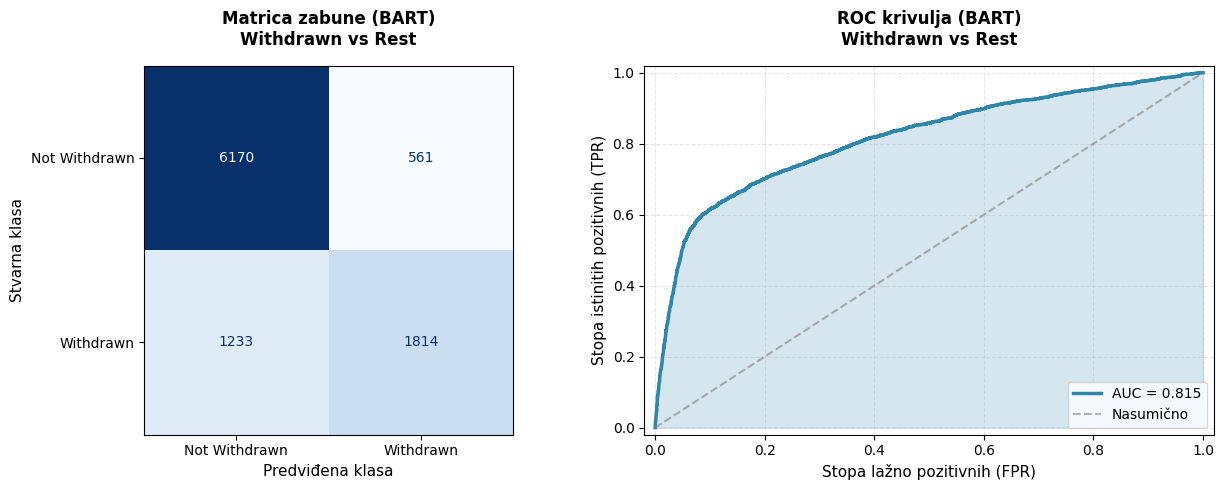

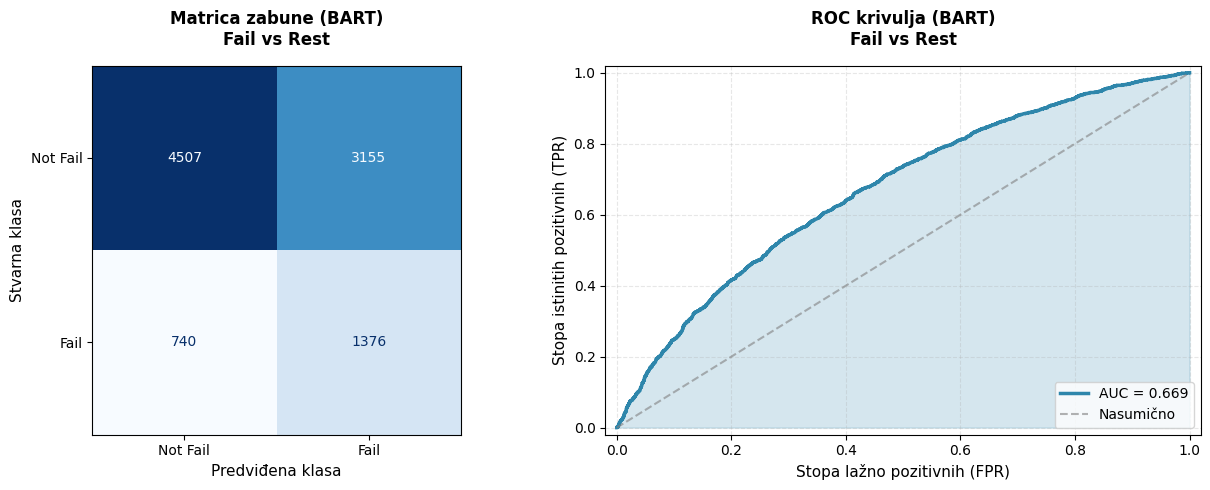

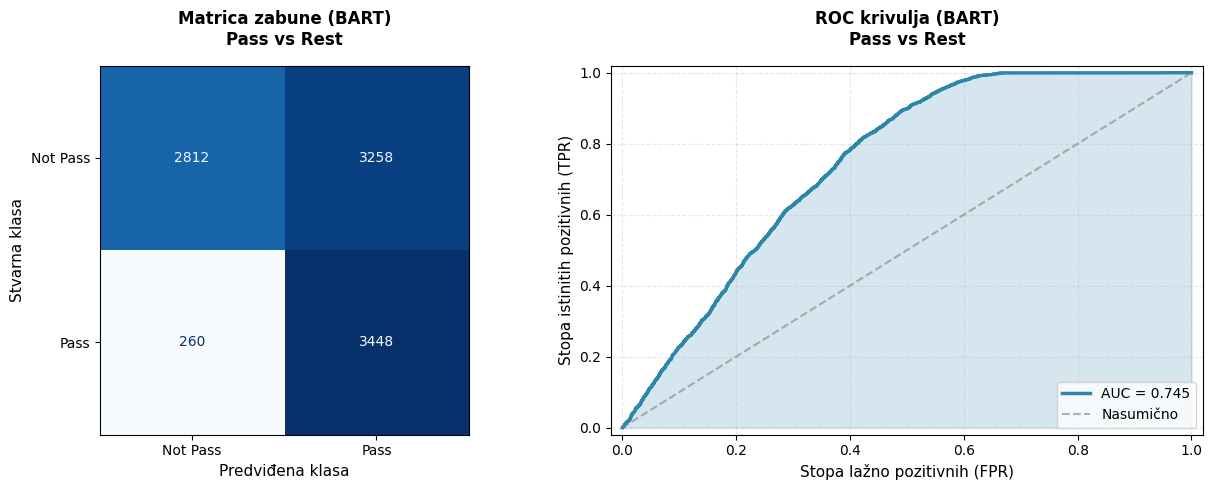

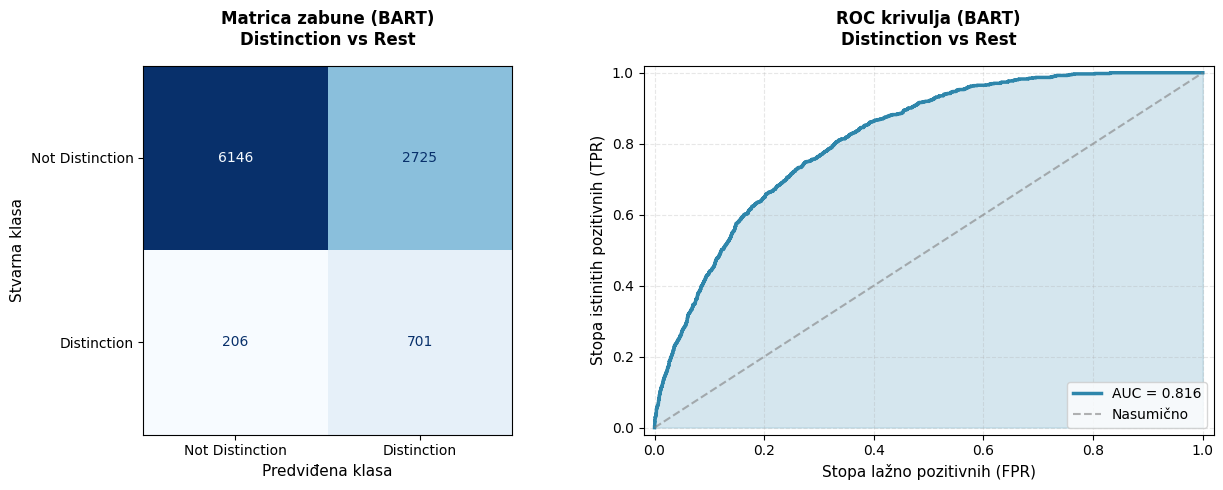

In [132]:
for res in bart_results:
    bart_visualize_results(res)

**Withdrawn vs Rest**  

Za klasu Withdrawn dobivena je AUC vrijednost od 0.814. Iz matrice zabune vidljivo je da model ispravno prepoznaje 1913 studenata koji su se povukli s kolegija, ali istovremeno propušta velik broj takvih slučajeva (1134 FN), što objašnjava umjerene vrijednosti recall metrike.

**Fail vs Rest**  

Za klasu Fail dobivena je AUC vrijednost 0.671, što predstavlja najslabiji rezultat među svim klasama i upućuje na izrazitu poteškoću modela u razdvajanju studenata koji nisu položili kolegij od ostalih. Iz svih modela korištenih do sad vidljivo je da je Fail najteža klasa za klasifikaciju. U članku je to slučaj za Pass, ipak su uspjeli postignuti nešto bolji rezultat za Fail.

**Pass vs Rest**

Za klasu Pass postignuta je AUC vrijednost 0.745, što ukazuje na neznatno poboljšanje u usporedbi s linearnom regresijom. Model posebno ima problema s lažno pozitivnim rezultatima s 3258 lažno pozitivna u samo 2812 predviđena negativna od ukupnih 6070 stvarno negativnih.

**Distinction vs Rest**  

Za klasu Distinction dobivena je AUC vrijednost 0.816,  što predstavlja najvišu AUC vrijednost među promatranim klasama za BART model, kao i općenito najbolji rezultat za sve modele do sad. Ipak, ka o što smo u ispisu iznad vidjeli, preciznost modela za Distinction je znatno lošija nego u članku. Model za značajan broj studenata lažno predviđa Distinction (2725). Do ovoga vjerojatno dolazi zbog neuravnoteženosti klase. Pokušaji over-samplinga tijekom testiranja nisu znatno pomogli.


## XGBoost

XGBoost je uključen kao napredni ansambl model temeljen na gradient boosting pristupu, koji se često pokazuje vrlo učinkovitim na tabličnim podacima. Model je treniran u višeklasnom načinu rada, a dodatno je evaluiran one-vs-rest pristupom (ROC krivulje, AUC i matrice zabune po klasi) radi izravne usporedbe s ostalim modelima.


XGBoost – multiclass rezultati:
              precision    recall  f1-score   support

 Distinction       0.49      0.11      0.18       907
        Fail       0.42      0.19      0.27      2116
        Pass       0.53      0.88      0.66      3708
   Withdrawn       0.74      0.60      0.66      3047

    accuracy                           0.57      9778
   macro avg       0.55      0.45      0.44      9778
weighted avg       0.57      0.57      0.53      9778



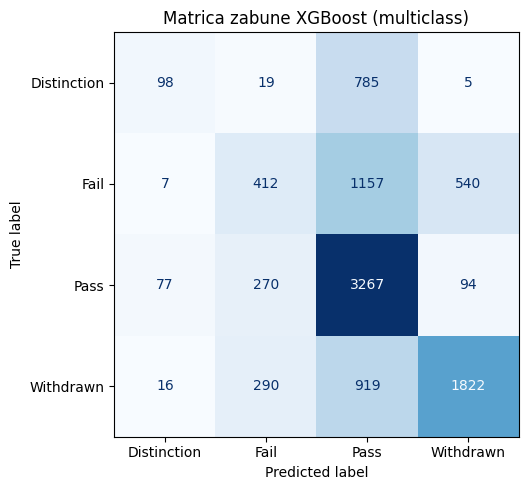

AUC (XGBoost, multiclass OvR): 0.7630283275189454

--- Evaluacija klase: Distinction vs Rest ---


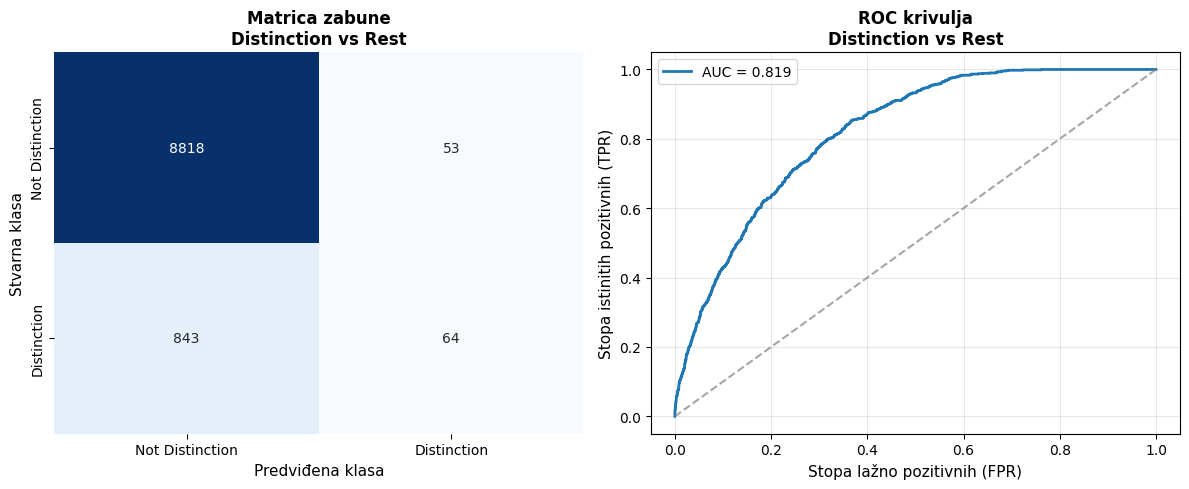


--- Evaluacija klase: Fail vs Rest ---


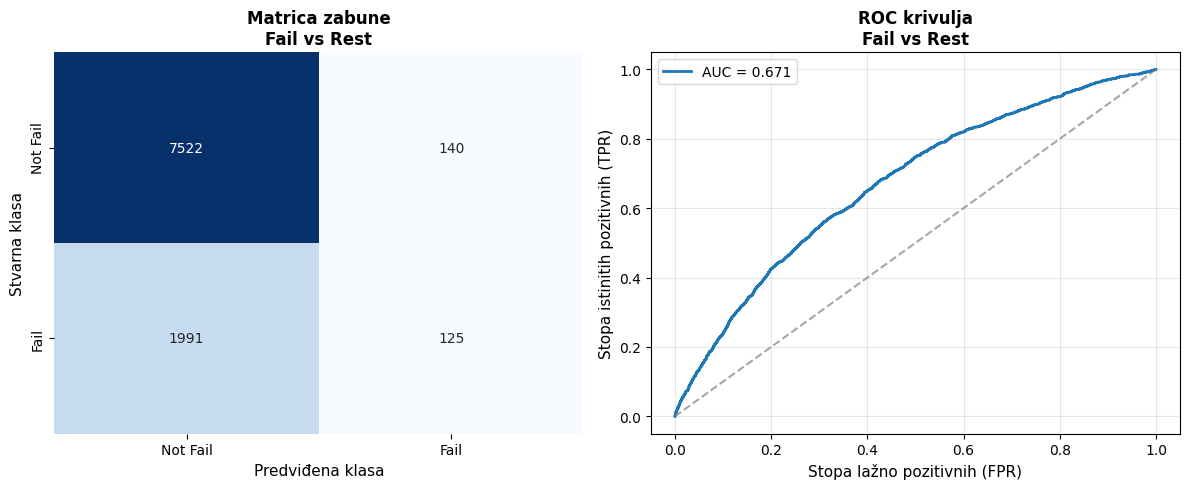


--- Evaluacija klase: Pass vs Rest ---


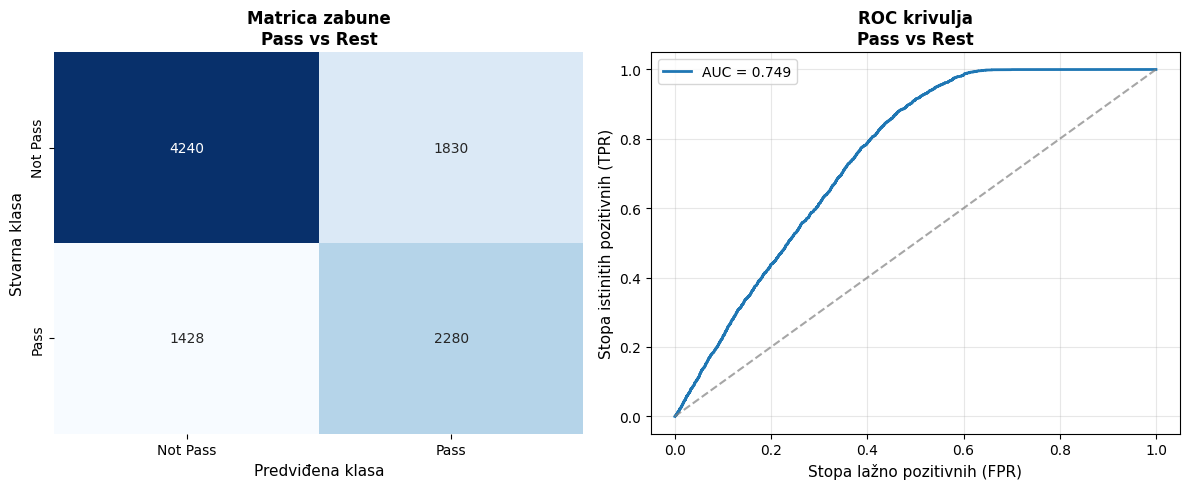


--- Evaluacija klase: Withdrawn vs Rest ---


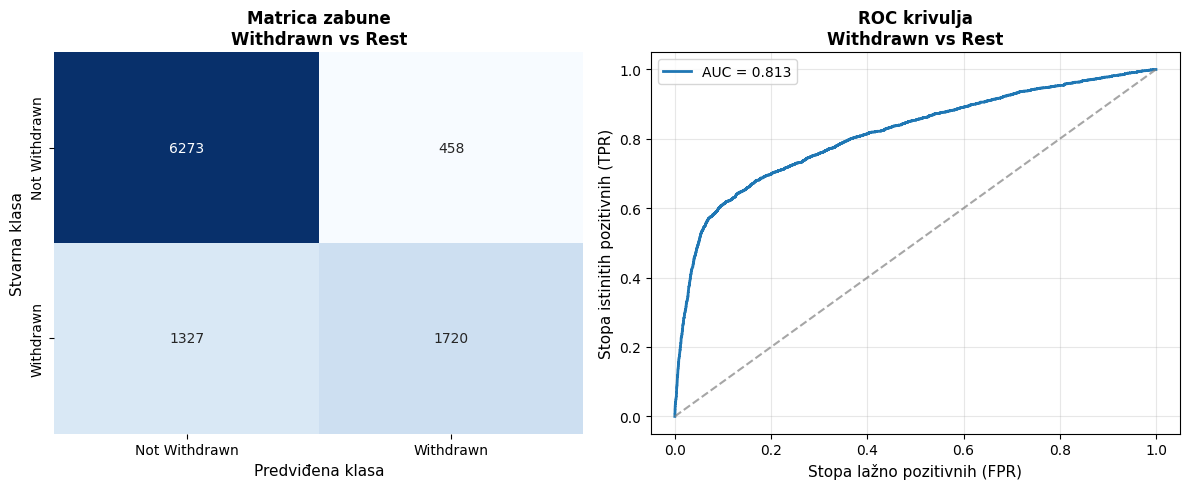

In [134]:

le = LabelEncoder()

y_train_enc = le.fit_transform(y_train)
y_test_enc  = le.transform(y_test)


xgb_pipeline = Pipeline([
    ("clf", XGBClassifier(
        objective="multi:softprob",
        num_class=len(le.classes_),
        n_estimators=400,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.9,
        colsample_bytree=0.9,
        reg_lambda=1.0,
        min_child_weight=1,
        gamma=0,
        eval_metric="mlogloss",
        n_jobs=-1,
        random_state=42
    ))
])

xgb_pipeline.fit(X_train, y_train_enc)


y_pred_xgb = xgb_pipeline.predict(X_test)
y_proba_xgb = xgb_pipeline.predict_proba(X_test)

# report s originalnim imenima klasa
print("XGBoost – multiclass rezultati:")
print(classification_report(
    y_test_enc, y_pred_xgb,
    target_names=le.classes_,
    zero_division=0
))

# multiclass confusion matrix
cm_xgb = confusion_matrix(y_test_enc, y_pred_xgb)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_xgb, display_labels=le.classes_)
fig, ax = plt.subplots(figsize=(6, 5))
disp.plot(ax=ax, cmap="Blues", values_format="d", colorbar=False)
ax.set_title("Matrica zabune XGBoost (multiclass)")
plt.tight_layout()
plt.show()

# AUC multiclass (OvR)
auc_xgb = roc_auc_score(y_test_enc, y_proba_xgb, multi_class="ovr")
print("AUC (XGBoost, multiclass OvR):", auc_xgb)

classes_to_check_enc = list(range(len(le.classes_)))

for c in range(len(le.classes_)):
    class_name = le.inverse_transform([c])[0]
    print(f"\n--- Evaluacija klase: {class_name} vs Rest ---")
    evaluate_ovr(xgb_pipeline, X_test, y_test_enc, c, label_encoder=le) 


**Distinction vs Rest**

Za klasu Distinction XGBoost postiže visoku AUC vrijednost od 0.849, što ukazuje na vrlo dobru sposobnost rangiranja studenata s izvrsnim uspjehom, uz jasno odvajanje ROC krivulje od dijagonale. Unatoč tome, matrica zabune pokazuje velik broj lažno negativnih predikcija: od stvarnih Distinction primjera 788 je pogrešno klasificirano kao Rest, dok je samo 119 ispravno prepoznato, što upućuje na konzervativan prag odlučivanja.


**Fail vs Rest**

Za klasu Fail XGBoost postiže AUC vrijednost od 0.727, što upućuje na umjerenu diskriminacijsku sposobnost, uz postupno, ali neizraženo odvajanje ROC krivulje od dijagonale. Matrica zabune pokazuje velik broj lažno negativnih predikcija: 1810 stvarnih Fail primjera klasificirano je kao Rest, dok je 306 ispravno prepoznato, a 340 lažno pozitivnih predikcija upućuje na povremenu pogrešnu identifikaciju drugih ishoda kao Fail.

**Pass vs Rest**

Za klasu Pass XGBoost postiže visoku AUC vrijednost od 0.823, što potvrđuje vrlo dobru diskriminacijsku sposobnost i pouzdano rangiranje ove klase. Matrica zabune pokazuje velik broj ispravno klasificiranih Pass primjera (2705), ali i znatan broj lažno pozitivnih predikcija (1541), što upućuje na dominantnost klase Pass i sklonost modela da je favorizira. Unatoč tome, Pass ostaje najstabilnija i najlakše predvidiva klasa za XGBoost.

**Withdrawn vs Rest**

Za klasu Withdrawn XGBoost postiže najvišu AUC vrijednost od 0.867, uz strm porast ROC krivulje pri niskim stopama lažno pozitivnih predikcija, što potvrđuje snažnu diskriminacijsku sposobnost. Matrica zabune pokazuje velik broj ispravno prepoznatih Withdrawn primjera (1808), uz umjeren broj lažno pozitivnih (535) i prisutne lažno negativne predikcije (1239). U odnosu na ostale klase, Withdrawn se pokazuje kao najlakša klasa za predikciju, a visoka AUC vrijednost potvrđuje prikladnost XGBoosta za ranu detekciju studenata sklonih povlačenju.


## Ograničenja analize

Iako su u analizi korišteni svi dostupni podaci na kojima je već izrađen rad, određena ograničenja i dalje postoje te ih je važno uzeti u obzir pri interpretaciji rezultata. Analiza je ograničena na varijable koje su bile dostupne u skupu podataka i definirane u okviru istraživanja, pri čemu se model temelji isključivo na informacijama koje su se mogle pouzdano rekonstruirati iz izvornog skupa podataka. Tijekom pokušaja replikacije rezultata uočen je problem konzistentnosti podataka, osobito kod varijable broj klikova prije početka kolegija, budući da je u izvornim CSV datotekama zabilježen samo ukupan broj klikova po studentu. Kako bi se osigurala usporedivost s postojećim radom, bilo je potrebno dodatno izdvojiti samo one interakcije koje su se dogodile prije službenog početka kolegija te tako konstruirati odgovarajuću varijablu, što može utjecati na točnost i ponovljivost analize. Glavno ograničenje analize predstavlja neuravnoteženost klasa, osobito za ishode Distinction i Fail, što može utjecati na stabilnost modela i interpretaciju dobivenih performansi. Nadalje, korištena one-vs-rest strategija klasifikacije, iako prikladna za probleme s više klasa i neuravnoteženim podacima, može dovesti do povećane osjetljivosti na preklapanje između susjednih kategorija, osobito u slučaju razreda Pass, koji se prirodno nalazi između razreda Fail i Distinction. Konačno, evaluacija modela temelji se na jednoj podjeli podataka na skup za učenje i testiranje, zbog čega dobivene performanse odražavaju specifičnosti korištenog skupa podataka i konteksta u kojem je prikupljen.


## Zaključak


In [135]:

def generate_complete_summary_table(models_results, bart_results):

    summary = []
    
    for model_name, (y_true, y_pred) in models_results.items():
        accuracy = accuracy_score(y_true, y_pred)
        macro_f1 = f1_score(y_true, y_pred, average='macro')
        
        report = classification_report(y_true, y_pred, output_dict=True, zero_division=0)
        classes = ['Withdrawn', 'Fail', 'Pass', 'Distinction']
        f1_scores = {cls: report[cls]['f1-score'] for cls in classes if cls in report}
        
        best_class = max(f1_scores, key=f1_scores.get)
        worst_class = min(f1_scores, key=f1_scores.get)
        
        # Provjeri bliske rezultate za najbolju klasu
        sorted_classes = sorted(f1_scores.items(), key=lambda x: x[1], reverse=True)
        if len(sorted_classes) > 1 and abs(sorted_classes[0][1] - sorted_classes[1][1]) < 0.03:
            best_class = f"{sorted_classes[0][0]} / {sorted_classes[1][0]}"
        
        summary.append({
            'Model': model_name,
            'Accuracy': accuracy,
            'Macro F1': macro_f1,
            'Najbolja klasa': best_class,
            'Najzahtjevnija klasa': worst_class
        })
    
    # BART
    if bart_results and len(bart_results) > 0:
        # Izvuci F1 scores za sve klase
        bart_f1_scores = {res['class']: res['f1'] for res in bart_results}
        
        # Najbolja i najzahtjevnija klasa
        bart_best_class = max(bart_f1_scores, key=bart_f1_scores.get)
        bart_worst_class = min(bart_f1_scores, key=bart_f1_scores.get)
        
        # Provjeri bliske rezultate
        sorted_bart = sorted(bart_f1_scores.items(), key=lambda x: x[1], reverse=True)
        if len(sorted_bart) > 1 and abs(sorted_bart[0][1] - sorted_bart[1][1]) < 0.03:
            bart_best_class = f"{sorted_bart[0][0]} / {sorted_bart[1][0]}"
        
        # Macro F1 - prosječna F1 svih klasa
        bart_macro_f1 = np.mean([res['f1'] for res in bart_results])

        # Prosječna OvR accuracy (aproksimacija)
        bart_avg_ovr_accuracy = np.mean([res['accuracy'] for res in bart_results])
        
        summary.append({
            'Model': 'BART',
            'Accuracy': bart_avg_ovr_accuracy,
            'Macro F1': bart_macro_f1,
            'Najbolja klasa': bart_best_class,
            'Najzahtjevnija klasa': bart_worst_class
        })
    
    df = pd.DataFrame(summary)
    
    # Sortiraj po Macro F1 (najbolji modeli gore)
    df = df.sort_values('Macro F1', ascending=False).reset_index(drop=True)
    
    return df

def display_summary_as_markdown(summary_df, bart_results):
    """
    Prikazuje sažetak performansi kao Markdown u Jupyter notebooku.
    """
    # Formatiraj brojeve
    df_formatted = summary_df.copy()
    df_formatted['Accuracy'] = df_formatted['Accuracy'].apply(lambda x: f"{x:.2f}")
    df_formatted['Macro F1'] = df_formatted['Macro F1'].apply(lambda x: f"{x:.2f}")
    
    # Generiraj Markdown string
    markdown_text = "## Sažetak rezultata\n\n"
    markdown_text += "U tablici je prikazan sažetak performansi svih korištenih modela. "
    markdown_text += "Prikazane su ukupne metrike te klase koje se pokazuju kao najlakše "
    markdown_text += "i najzahtjevnije za predikciju.\n\n"
    
    # Dodaj tablicu
    markdown_text += df_formatted.to_markdown(index=False)
    markdown_text += "\n\n"
    
    # Dodaj napomenu za BART
    markdown_text += "**Napomena:** *BART metrike su agregirane iz One-vs-Rest pristupa. "
    markdown_text += "Accuracy predstavlja prosječnu OvR accuracy, što može biti viša od "
    markdown_text += "prave multiclass accuracy. Macro F1 je izračunat kao prosječna F1-mjera "
    markdown_text += "svih OvR modela.*\n\n"

    
    # Prikaži kao Markdown
    display(Markdown(markdown_text))


In [136]:
# ===== PRIPREMA PODATAKA =====

# Skupi rezultate standardnih modela
models_results = {
    'Decision Tree': (y_test, y_pred_dt),
    'Random Forest': (y_test, y_pred_rf),
    'Logistička regresija': (y_test, y_pred_logreg),
    'XGBoost': (y_test, le.inverse_transform(y_pred_xgb))
}

# Geneririraj tablicu
summary_df = generate_complete_summary_table(models_results, bart_results)
display_summary_as_markdown(summary_df, bart_results)


## Sažetak rezultata

U tablici je prikazan sažetak performansi svih korištenih modela. Prikazane su ukupne metrike te klase koje se pokazuju kao najlakše i najzahtjevnije za predikciju.

| Model                |   Accuracy |   Macro F1 | Najbolja klasa   | Najzahtjevnija klasa   |
|:---------------------|-----------:|-----------:|:-----------------|:-----------------------|
| BART                 |       0.69 |       0.52 | Withdrawn / Pass | Distinction            |
| XGBoost              |       0.57 |       0.44 | Pass / Withdrawn | Distinction            |
| Random Forest        |       0.52 |       0.43 | Withdrawn / Pass | Distinction            |
| Logistička regresija |       0.57 |       0.37 | Pass / Withdrawn | Distinction            |
| Decision Tree        |       0.39 |       0.37 | Withdrawn        | Distinction            |

**Napomena:** *BART metrike su agregirane iz One-vs-Rest pristupa. Accuracy predstavlja prosječnu OvR accuracy, što može biti viša od prave multiclass accuracy. Macro F1 je izračunat kao prosječna F1-mjera svih OvR modela.*



### Rasprava rezultata

Dobiveni rezultati u velikoj su mjeri u skladu s nalazima prethodnih istraživanja u području learning analytics i predikcije studentskog uspjeha, koja pokazuju da je ranu akademsku izvedbu i angažman moguće koristiti kao pouzdane indikatore konačnog ishoda kolegija. Posebno visoke performanse zabilježene su za ishode Withdrawn i Distinction, što potvrđuje zaključke ranijih studija prema kojima studenti koji odustaju ili ostvaruju iznimno visoke rezultate pokazuju jasnije i konzistentnije obrasce ponašanja u ranim fazama učenja. Takvi obrasci uključuju nizak ili vrlo visok stupanj aktivnosti u virtualnom okruženju za učenje te izražene razlike u rezultatima prvih provjera znanja, što je već identificirano kao snažan prediktor uspjeha u ranijim radovima.

Nasuprot tome, razred Pass pokazao je slabije performanse klasifikacije, što je također u skladu s postojećom literaturom koja ističe da su srednje kategorije uspjeha teže razlučive u odnosu na ekstremne ishode. Studenti koji ostvare prolaznu ocjenu često dijele obilježja i s uspješnijim i s neuspješnijim studentima, zbog čega dolazi do većeg preklapanja u prostoru značajki. Ovakav rezultat potvrđuje nalaze istraživanja koja naglašavaju da binarna ili grubo pojednostavljena podjela studenata može prikriti važne razlike unutar skupina, ali i da finija klasifikacija nužno donosi dodatne izazove u pogledu modeliranja i interpretacije.

Neuravnoteženost klasa pokazala se kao jedno od ključnih ograničenja, što je također često istican problem u sličnim studijama. Literatura navodi da kod obrazovnih podataka ishodi poput Distinction i Withdrawn prirodno čine manji udio ukupne populacije, što može dovesti do pristranosti modela prema dominantnim klasama. Iako primjena one-vs-rest strategije omogućuje korištenje standardnih binarnih klasifikatora i usporedivost s prethodnim radovima, takav pristup dodatno naglašava osjetljivost modela na neravnomjernu distribuciju podataka, što se očituje u varijabilnosti metrika poput preciznosti i odziva.

Rezultati dodatno potvrđuju važnost ponašajnih varijabli, osobito broja klikova i rezultata prve provjere znanja, što je u skladu s brojnim prethodnim istraživanjima koja ističu angažman u sustavu za učenje kao jedan od najvažnijih čimbenika uspjeha. Time se potvrđuje pretpostavka da se značajan dio informacija o budućem uspjehu može dobiti vrlo rano, čak i prije formalnog početka nastave. Međutim, u procesu replikacije rezultata uočeno je da način konstrukcije pojedinih varijabli, poput broja klikova prije početka kolegija, može značajno utjecati na ishode analize, što je problem koji literatura sve češće ističe u kontekstu ponovljivosti i transparentnosti istraživanja u području obrazovne analitike.

Sveukupno, rezultati ovog rada potvrđuju nalaze prethodnih studija da je ranu predikciju studentskog uspjeha moguće ostvariti s relativno visokom točnošću, ali i naglašavaju da povećanje granularnosti klasifikacije, iako metodološki opravdano i korisno za praktične intervencije, donosi dodatne izazove.

U odnosu na izvorni članak, ovaj rad donosi nekoliko metodoloških i analitičkih novosti. Za razliku od izvornog pristupa, provedena je detaljna replikacija cjelokupnog postupka obrade i analize podataka, pri čemu su identificirani i eksplicitno dokumentirani problemi konzistentnosti podataka, osobito u konstrukciji varijable broja klikova prije početka kolegija, koja u izvornom skupu podataka nije bila izravno dostupna. Nadalje, u radu je provedena sustavna evaluacija višeklasne klasifikacije kroz one-vs-rest strategiju uz naglasak na neuravnoteženost klasa i njezin utjecaj na performanse modela, što u izvornom članku nije dodatno analizirano. Time se ne samo potvrđuju temeljni zaključci prethodnog istraživanja, već se proširuje njihova interpretacija kroz kritički osvrt na replikabilnost, robusnost modela i osjetljivost rezultata na način pripreme podataka.